In [1]:
import numpy as np
from matplotlib import pyplot as plt
import types
import itertools
import copy
from scipy.linalg import svd as svd
from sklearn.datasets import make_swiss_roll
%matplotlib notebook

## GTM Object

In [2]:
class GTM(object):
    
    def __init__(self, n_components, latent_size, basis = 'gaussian', n_basis = None, latent_range = [-1, 1], n_init = 1, max_iter = 300, sigma = 1, tol = 0.001, reg_covar = 1e-3, standardise_flag = True, verbose = False, vectorise = False, precision_flag = False):
        pass
    
        #Initialise attributes
        self.n_components = n_components
        self.latent_size = latent_size
        self.n_points = int(self.n_components ** self.latent_size)
        self.basis = basis
        
        if n_basis is None:
            self.n_basis = int(self.n_components**self.latent_size)
            #Only for if you use gaussian basis functions and need to figure out how many you need
            
        
        else:
            self.n_basis = n_basis #use prescribed number of basis vectors in k-means clustering
                
        self.latent_range = latent_range
        self.n_init = n_init
        self.max_iter = max_iter
        self.sigma = sigma
        self.tol = tol
        self.reg_covar = reg_covar
        self.standardise_flag = standardise_flag
        self.verbose = verbose
        self.vectorise = vectorise
        self.precision_flag = precision_flag
        
        #Define mixture coefficients
        self.mix_ = np.ones(self.n_points) / self.n_points
        
        #make grid and latent points
        self.make_grid()
        
        #initialise basis functions
        self.basis_initialisation()
        
        #Check basis
        self.check_basis()
        
        #useful attributes
        self.weight_ = None
        self.variance_ = None
        
        
    def make_grid(self):
        
        if self.latent_size == 1:
            self.means_ = np.linspace(self.latent_range[0], self.latent_range[1], self.n_components)
            self.grid_points = np.arange(0, self.n_components, 1)
        
        elif self.latent_size == 2:
            X, Y = np.meshgrid(np.linspace(self.latent_range[0], self.latent_range[1], self.n_components), 
                           np.linspace(self.latent_range[0], self.latent_range[1], self.n_components))
        
            P1, P2 = np.meshgrid(np.arange(0, self.n_components, 1), 
                               np.arange(0, self.n_components, 1))

            self.means_ = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
            self.grid_points = np.hstack((P1.reshape(-1, 1), P2.reshape(-1, 1)))
        
        else:
            print("Latent size is too large.")
            raise SystemExit
    
    def initialise_gaussian_centers(self):
        
        if self.n_basis == self.n_points:
            self.gauss_centers = self.means_
        
        elif self.n_basis < self.n_points:
            print("K-means version not implemented.")
            raise SystemExit
        
        else:
            print("You cannot have more kernel centers ({}) than available latent points ({}).".format(self.n_basis, self.n_points))
            raise SystemExit
    
        
    def polynomal_basis(self, x):
        
        if not hasattr(self, "poly_powers"):
            f = x.shape[0]
            self.poly_powers = np.array(list(itertools.combinations_with_replacement(range(0, self.orders + 1), f)))
        
        return np.product(x.T**self.poly_powers, axis = 1, keepdims = True)
    
    def gaussian_basis(self, x): #np.exp(-1 * sigma / 2 * ||x - c||_2^2)
        
        if self.vectorise:
            
            errors = np.sum((self.gauss_centers - x.T)**2, axis = 1, keepdims = True)
        
        else:
            errors = np.zeros((self.n_basis, 1))
            
            for i in range(self.n_basis):
                errors[i, 0] = np.sum((self.gauss_centers[[i], :] - x.T)**2, axis = 1)
        
        return np.exp(-1 * self.sigma/2 * errors)
    
    def basis_initialisation(self):
        
        if isinstance(self.basis, types.FunctionType):
            self.basis_function = self.basis
            
            #check basis
            self.check_basis()
            
        elif isinstance(self.basis, str):
            
            if self.basis.lower() == "linear":
                
                self.basis_function = self.polynomal_basis
                self.orders = 1
            
            elif self.basis.lower() == "quadratic":
                
                self.basis_function = self.polynomal_basis
                self.orders = 2
                
            elif self.basis.lower() == "cubic":
                
                self.basis_function = self.polynomal_basis
                self.orders = 3
                
            elif self.basis.lower() == "quartic":
                
                self.basis_function = self.polynomal_basis
                self.orders = 4
            
            elif self.basis.lower() == 'gaussian':
                self.initialise_gaussian_centers()
                self.basis_function = self.gaussian_basis
                self.orders = None
        
        else:
            print("Unknown basis entered.")
            raise SystemExit
    
    def check_basis(self):
        #check function
            x = np.zeros((self.latent_size, 1))
            
            r, c = self.basis_function(x).shape
            
            assert(c == 1), print("Basis function does not return vectors: {} x {} output".format(r, c))
    
    def evaluate_gauss(self, x, mu, covariance, precision = None):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1) #reshape mu
            
            if precision is None:
                precision = np.linalg.inv(covariance) #This is fine as we have a spherical covariance (diag[Beta])
            
            second_part = np.exp((-1 / 2) * np.sum(np.dot(z, precision) * z, axis = 1))
        
        else: #vector inputs for mu and x_vec
            D = x.shape[0]
            z = x - mu
        
            second_part = np.exp((-1 / 2) * np.dot(z.T, np.linalg.solve(covariance, z)))
            
        first_part = 1 / ((2 * np.pi)**(D / 2))  * 1 / (np.linalg.det(covariance)**(1/2))
        
        return first_part * second_part
    
    def evaluate_log_gauss(self, x, mu, covariance, precision = None):
        #All vector/matrix inputs (so that shape is fine)
        #You could also store the precisions, may make this evaluation faster
        
        if self.vectorise:
            D = x.shape[1]
            z = x - mu.reshape(1, -1)
            
            if precision is None:
                precision = np.linalg.inv(covariance) #This is fine as we have a spherical covariance (diag[Beta])

            
            third_part = -1/2 * np.sum(np.dot(z, precision) * z, axis = 1)
        
        else:     
            D = x.shape[0]
            z = x - mu
            third_part = -1/2 * np.dot(z.T, np.linalg.solve(covariance, z))

        first_part = -D/2 * np.log(2 * np.pi)
        second_part = -1/2 * np.log(np.linalg.det(covariance))
        
        return first_part + second_part + third_part
    
    def data_likelihood(self, x): #p(x)
        
        #use log-sum-exp to ensure that you do not hit numerical underflow!
        mix = self.mix_
        mu = self.forward_propagate_means() #Actually Mi = y(W, u_i)
        cov = np.eye(self.n_features) / self.variance_
        
        if self.precision_flag:
            prec = np.eye(self.n_features) * self.variance_
        
        else:
            prec = None
        
        if x.shape[1] == 1:
            N = 1
        else:
            N = x.shape[0]
        
        log_likelihoods = np.zeros((N, self.n_points))
        
        for k in range(self.n_points):
            
            mean_vec = mu[[k], :].T #N x 1 vector
            
            if N == 1:
                log_likelihoods[0, k] = self.evaluate_log_gauss(x, mean_vec, cov, prec) + np.log(mix[k])
                
            elif N != 1 and self.vectorise:
                log_likelihoods[:, k] = self.evaluate_log_gauss(x, mean_vec, cov, prec) + np.log(mix[k])
            
            if N != 1 and not self.vectorise:
                
                for i in range(N):
                    log_likelihoods[i, k] = self.evaluate_log_gauss(x[[i], :].T, mean_vec, cov) + np.log(mix[k])

        #Apply log-sum-exp trick
        A = np.max(log_likelihoods, axis = 1, keepdims=True)
    
        log_likelihood_sum = A + np.log(np.sum(np.exp(log_likelihoods - A), axis = 1, keepdims = True))
        
        p_x = np.exp(log_likelihood_sum)
        
        return p_x, log_likelihoods, log_likelihood_sum
    
    def posterior_likelihood(self, x): #Calculates the responsibilities 
        
        _, log_likelihoods, log_likelihood_sum = self.data_likelihood(x)
        
        responsibility = np.exp(log_likelihoods - log_likelihood_sum)
        
        return responsibility
    
    def log_likelihood(self, X, sum_flag = True): #return the log-likelihood sum
        
        N = X.shape[0]
        LL = np.zeros((N, 1))
        
        if self.vectorise:
            LL = self.data_likelihood(X)[2]
        
        else:
            for i in range(N):

                x_vec = X[[i], :].T #N x 1 vector

                #Add log-likelihood
                LL[i, 0] = self.data_likelihood(x_vec)[2]
        
        if sum_flag:
            return np.mean(LL)
        
        else:
            return LL
    
    def PCA_fit(self, X):
        
        if not hasattr(self, "mean_"):
            self.mean_ = np.mean(X, axis = 0)
        
        #Decompose X
        U, s, Vh = svd(X - self.mean_, full_matrices = False)
        
        #Perform sign correction to ensure consistent SVD output
        U, Vh = self.svd_flip(U, Vh)
        
        if self.latent_size < self.n_features:
            #Explained variance (eigenvalues)
            self.PCA_eigenvalues_ = s**2 / (self.n_samples - 1)

        
        else:
            #Explained variance (eigenvalues)
            self.PCA_eigenvalues_ = s**2 / (self.n_samples - 1)
        
        #Save important components
        self.U = U
        self.s = s
        self.PCA_components_ = Vh[:self.latent_size]
        self.variance_ = self.PCA_eigenvalues_[self.latent_size]
    
    def svd_flip(self, u, v, u_based_decision=True):
        """Sign correction to ensure deterministic output from SVD.
        Adjusts the columns of u and the rows of v such that the loadings in the
        columns in u that are largest in absolute value are always positive.
        Parameters
        ----------
        u : ndarray
            u and v are the output of `linalg.svd` or
            :func:`~sklearn.utils.extmath.randomized_svd`, with matching inner
            dimensions so one can compute `np.dot(u * s, v)`.
        v : ndarray
            u and v are the output of `linalg.svd` or
            :func:`~sklearn.utils.extmath.randomized_svd`, with matching inner
            dimensions so one can compute `np.dot(u * s, v)`.
            The input v should really be called vt to be consistent with scipy's
            output.
        u_based_decision : bool, default=True
            If True, use the columns of u as the basis for sign flipping.
            Otherwise, use the rows of v. The choice of which variable to base the
            decision on is generally algorithm dependent.
        Returns
        -------
        u_adjusted, v_adjusted : arrays with the same dimensions as the input.
        """
        if u_based_decision:
            # columns of u, rows of v
            max_abs_cols = np.argmax(np.abs(u), axis=0)
            signs = np.sign(u[max_abs_cols, range(u.shape[1])])
            u *= signs
            v *= signs[:, np.newaxis]
        else:
            # rows of v, columns of u
            max_abs_rows = np.argmax(np.abs(v), axis=1)
            signs = np.sign(v[range(v.shape[0]), max_abs_rows])
            u *= signs
            v *= signs[:, np.newaxis]
        return u, v
    
    def standardise(self, X, reverse_flag = False):
        
        if reverse_flag:
            
            if hasattr(self, "mean_") and hasattr(self, "std_"):
            
                return X * self.std_ + self.mean_
            
            else:
                print("Error in standardisation. No mean_ and std_ attributes")
                raise SystemExit
        
        else:
            self.mean_ = np.mean(X, axis = 0, keepdims = True)
            self.std_ = np.std(X, axis = 0, keepdims = True)

            return (X - self.mean_) / self.std_
    
    def initialise_weights(self, X):
        
        #Solve for Vh
        self.PCA_fit(X)
        
        #Determine targets
        T = np.dot(self.means_, self.PCA_components_)
        
        ATA = np.dot(self.B_matrix.T, self.B_matrix)
        ATB = np.dot(self.B_matrix.T, T)
        
        weights = np.linalg.solve(ATA, ATB)
        
        return weights.T
    
    
    def basis_matrix(self):
        n_samples = self.means_.shape[0]
        
        b_mat = []
        
        for i in range(n_samples):
            b_out = self.basis_function(self.means_[[i], :].T)
            b_mat.append(b_out[:, 0])
            
        return np.array(b_mat) #N x M matrix
    
    def forward_propagate_means(self):
        
        return np.dot(self.B_matrix, self.weights_.T)
    
    def update_R(self, X):
        #Update R and G based on old weights
        self._R = self.posterior_likelihood(X)
        self._G = np.diag(np.sum(self._R, axis = 0))
    
    def update_W(self, X):
        
        #Solve for new weights
        ATGA = np.dot(np.dot(self.B_matrix.T, self._G), self.B_matrix)
        ATRB = np.dot(np.dot(self.B_matrix.T, self._R.T), X)
        
        Wnew = np.linalg.solve(ATGA, ATRB)
        
        return Wnew.T
    
    def update_variance(self, X):
        
        N, D = X.shape
        
        M = self.forward_propagate_means()
        
        variance_new = 0
        
        for i in range(self.n_points):
            variance_new += np.sum(self._R[:, i] * np.sum((X - M[[i], :])**2, axis = 1))
        
        return variance_new / (N * D)
    
    
    def fit(self, X):
        
        self.n_samples, self.n_features = X.shape
        
        if self.standardise_flag:
            X = copy.deepcopy(X)
            X = self.standardise(X, reverse_flag = False)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_ll = np.inf
        optimal_outer = None
        
        for outer_iter in range(self.n_init):
            
            #Determine B matrix (constant)
            self.B_matrix = self.basis_matrix()

            #Initialise weight matrix
            self.weights_ = self.initialise_weights(X)

            local_ll_list = [self.log_likelihood(X)]
            tol = np.inf
            cnt = 0
            
            if self.verbose:
                print("\n Beginning outer iteration {}...".format(outer_iter))

            while cnt < self.max_iter and tol > self.tol:
                #Update R
                self.update_R(X)

                #Update W
                self.weights_ = self.update_W(X)

                #Update variance
                self.variance_ = 1 / self.update_variance(X) + self.reg_covar

                #Calculate likelihood
                new_LL = self.log_likelihood(X)
                tol = np.abs(new_LL - local_ll_list[-1])
                
                #Finalise iteration
                cnt += 1
                local_ll_list.append(new_LL)
                
                if self.verbose:
                    print("Inner iteration {}: \nlog-likelihood: {}, tol: {}".format(cnt, new_LL, tol))
            
            #Check convergence
            if cnt <= self.max_iter or tol <= self.tol:
                converged = True

            else:
                converged = False
            
            #Store components
            iter_dict[str(outer_iter)] = {"latent_means":self.means_,
                                          "variance":self.variance_,
                                          "weights":self.weights_,
                                          "loss_list":local_ll_list,
                                          "n_iter":cnt,
                                          "converged":converged}
            
            if optimal_ll > local_ll_list[-1]:
                optimal_ll = local_ll_list[-1]
                optimal_outer = outer_iter
        
        self.means_ = iter_dict[str(optimal_outer)]["latent_means"]
        self.variance_ = iter_dict[str(optimal_outer)]["variance"]
        self.weights_ = iter_dict[str(optimal_outer)]["weights"]
        self.loss_train_ = iter_dict[str(optimal_outer)]["loss_list"]
        self.lower_bound_ = iter_dict[str(optimal_outer)]["loss_list"][-1]
        self.n_iter_ = iter_dict[str(optimal_outer)]["n_iter"]
        self.converged = iter_dict[str(optimal_outer)]["converged"]
        
        if self.verbose:
            print("\nFinished GTM training!\n")
            print("Converged: {}".format(self.converged))
            
        return self 
    
    def transform(self, X):
        
        responsibility = np.sum(self.posterior_likelihood(X), axis = 0)
        
        if self.latent_size == 1:
            return responsibility.reshape(-1, 1)
        
        if self.latent_size == 2:
            return responsibility.reshape(self.n_components, self.n_components)
        
    def predict(self, X):
        pass
    
    def fit_predict(self, X):
        pass
    
    @staticmethod
    def sample_gaussian(n_points, mean, covariance):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        n_features = covariance.shape[0]
        
        eig_vals, eig_vect = np.linalg.eig(covariance)
        
        if np.sum(eig_vals > 0) == n_features:
            #print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(covariance)
            
        elif np.sum(eig_vals >= 0) == n_features:
            #print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        z = np.random.randn(n_points, n_features)
        x_samples = mean + np.dot(A, z.T).T
        
        return x_samples
    
    def sample(self, n_samples = 1):
        
        mix = self.mix_
        means = self.forward_propagate_means() #Actually Mi = y(W, u_i)
        cov = np.eye(self.n_features) / self.variance_
        
        cumsum = np.cumsum(mix)
        
        n_classes = np.zeros(len(mix), dtype = int)
        
        #Select centers
        rand_sample = np.random.rand(n_samples)
        
        #Collect per class
        for i in rand_sample:
            pos_select = np.argmin(np.abs(cumsum - i)) - 1
            n_classes[pos_select] += 1
        
        print(n_classes)
        
        #Sample per class
        Xlist = []
        
        for k, n_points in enumerate(n_classes):
            
            Xlist.append(self.sample_gaussian(n_points, means[k, :], cov))
        
        Xsample = np.concatenate(Xlist, axis=0)
        
        #Generate labels
        labels = []
        
        for cnt, i in enumerate(n_classes):
            labels += [cnt] * i
        
        return Xsample, labels
    
    def score(self, X):
        return self.log_likelihood(X, sum_flag = True)
    
    def score_samples(self, X):
        return self.log_likelihood(X, sum_flag = False)
    

## Swiss roll dataset

<IPython.core.display.Javascript object>


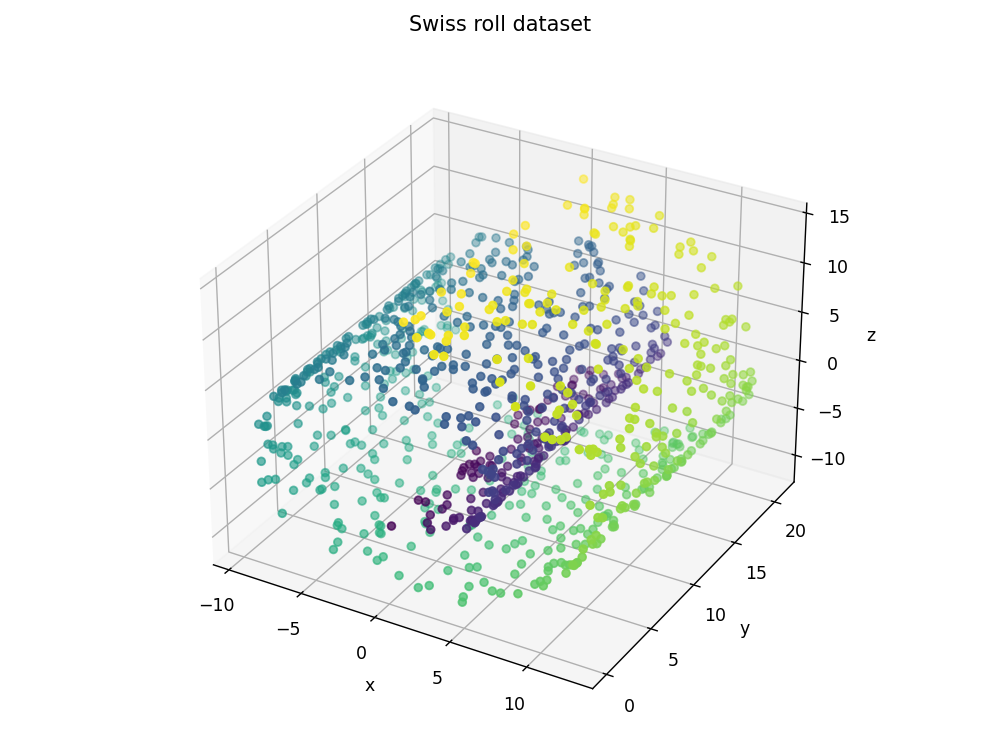

In [3]:
X, l = make_swiss_roll(n_samples=1000, noise=0.0, random_state=None)
fig = plt.figure(figsize = (8, 6))
fig.suptitle("Swiss roll dataset")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = l)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
plt.show()

## Train GTM instance

In [4]:
gtm = GTM(n_components = 25,
        latent_size = 2,
        basis = 'gaussian',
        n_basis = None,
        latent_range = [-1, 1],
        n_init = 1,
        max_iter = 300,
        sigma = 100,
        tol = 0.001,
        reg_covar = 0.001,
        standardise_flag = True,
        verbose = True,
        vectorise = True,
        precision_flag =True).fit(X)
  


 Beginning outer iteration 0...
Inner iteration 1: 
log-likelihood: -4.248672374196569, tol: 0.05873013770643798
Inner iteration 2: 
log-likelihood: -4.247349116622774, tol: 0.0013232575737944785
Inner iteration 3: 
log-likelihood: -4.24609073516147, tol: 0.0012583814613043032
Inner iteration 4: 
log-likelihood: -4.244767241618653, tol: 0.0013234935428174666
Inner iteration 5: 
log-likelihood: -4.243270218383814, tol: 0.0014970232348385792
Inner iteration 6: 
log-likelihood: -4.241472808955589, tol: 0.0017974094282253716
Inner iteration 7: 
log-likelihood: -4.239202006750504, tol: 0.0022708022050847987
Inner iteration 8: 
log-likelihood: -4.236205291835191, tol: 0.00299671491531317
Inner iteration 9: 
log-likelihood: -4.232104078089129, tol: 0.0041012137460620934
Inner iteration 10: 
log-likelihood: -4.226324489528019, tol: 0.005779588561109605
Inner iteration 11: 
log-likelihood: -4.2179933156039535, tol: 0.00833117392406546
Inner iteration 12: 
log-likelihood: -4.20579764229654, tol

### Visualise results

<IPython.core.display.Javascript object>


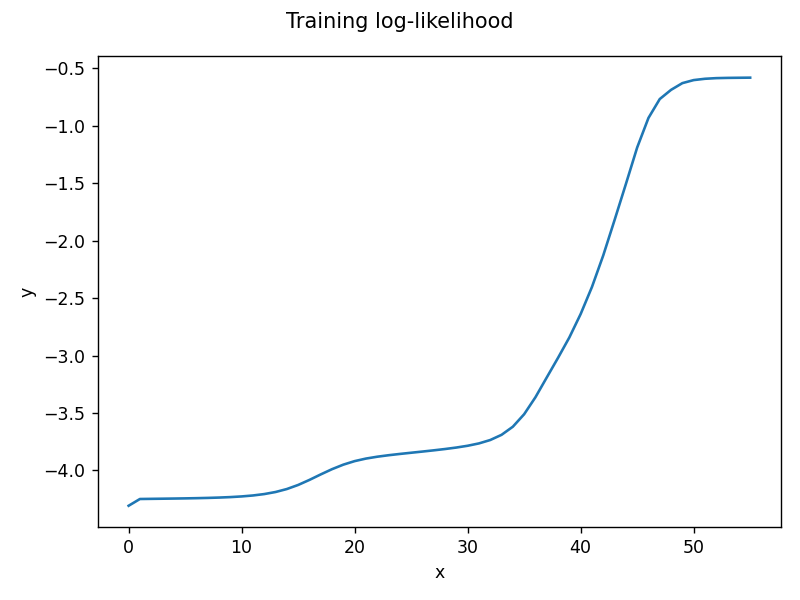

<IPython.core.display.Javascript object>


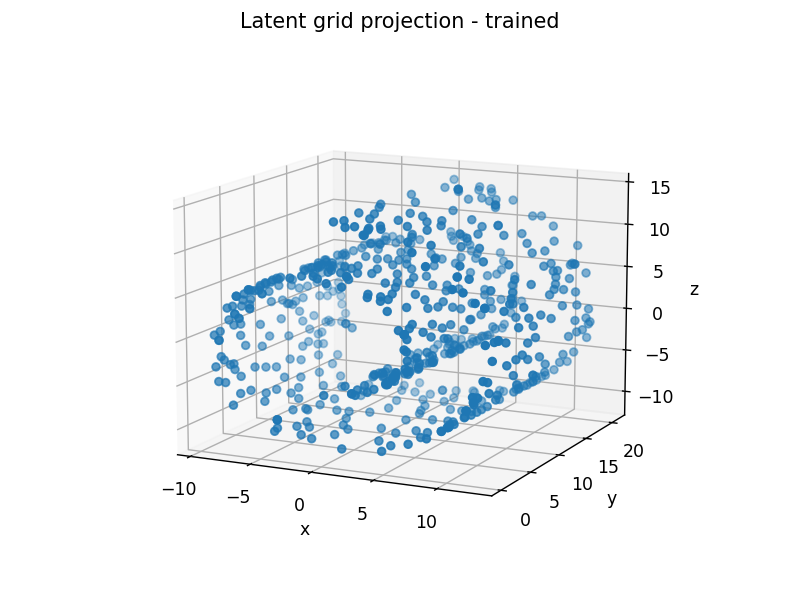

<IPython.core.display.Javascript object>


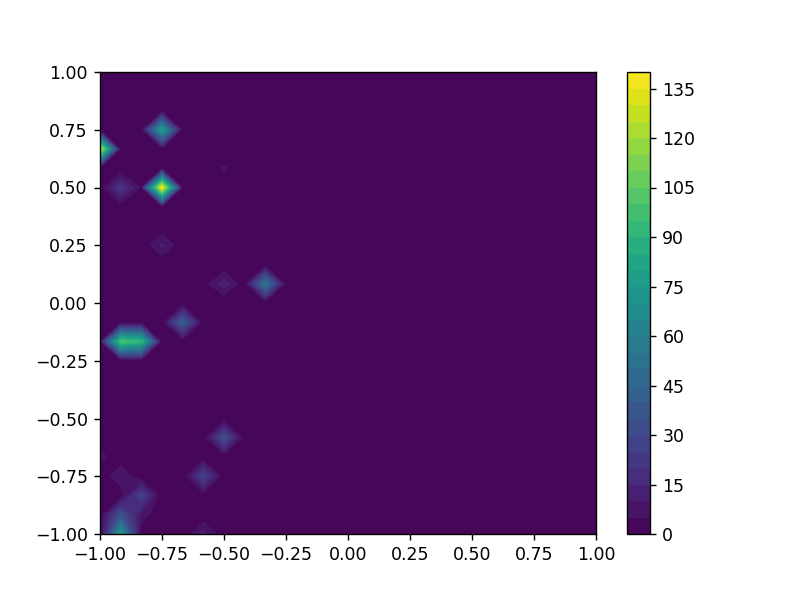

<IPython.core.display.Javascript object>


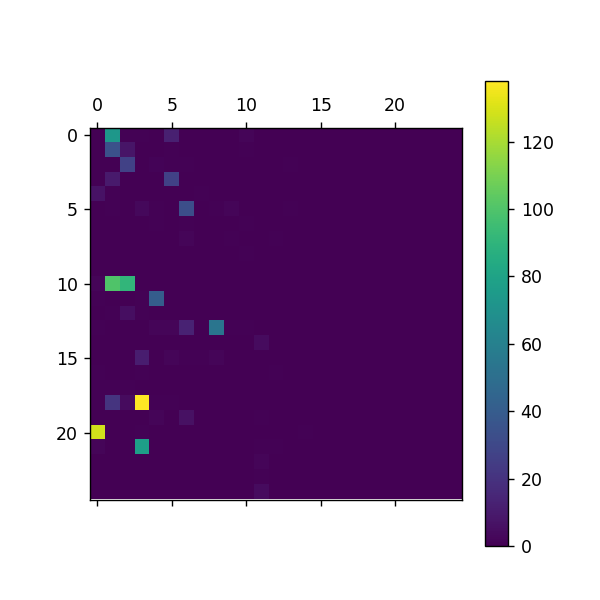

<IPython.core.display.Javascript object>


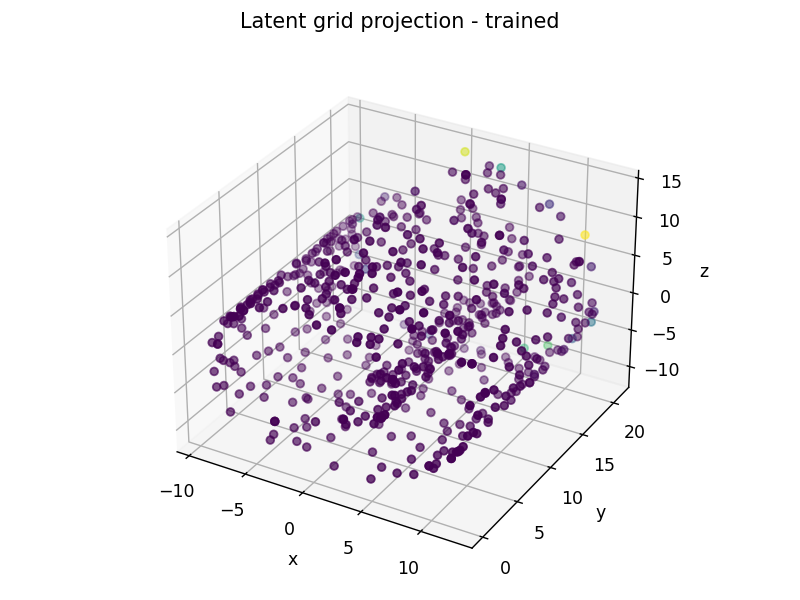

In [5]:
fig, ax = plt.subplots()
fig.suptitle("Training log-likelihood")
ax.plot(gtm.loss_train_)
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.tight_layout()
plt.show()       

L = gtm.forward_propagate_means() * gtm.std_ + gtm.mean_

fig = plt.figure()
fig.suptitle("Latent grid projection - trained")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L[:, 0], L[:, 1], L[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
plt.show()     

resp_mat = gtm.transform(X)
#resp_mat /= np.max(resp_mat)

plt.figure()
plt.contourf(gtm.means_[:, 0].reshape(gtm.n_components, gtm.n_components), 
             gtm.means_[:, 1].reshape(gtm.n_components, gtm.n_components), 
             resp_mat, levels = 30)
plt.colorbar()
plt.show()

plt.matshow(resp_mat)
plt.colorbar()
plt.show()

fig = plt.figure()
fig.suptitle("Latent grid projection - trained")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(L[:, 0], L[:, 1], L[:, 2], c = resp_mat.reshape(-1))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
plt.show()      

### Take a slice in the y-z plane (fix y) and look at in in 2D

standardised the data


<IPython.core.display.Javascript object>


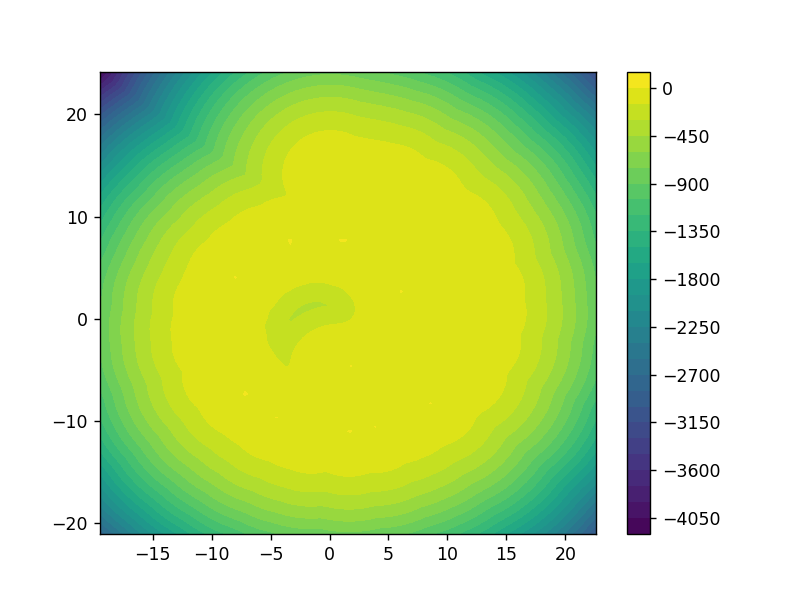

In [6]:
N = 100
y_const = 10

Xnew, Znew = np.meshgrid(np.linspace(np.min(X[:, 0]) - 10, np.max(X[:, 0]) + 10, N),
                   np.linspace(np.min(X[:, 2]) - 10, np.max(X[:, 2]) + 10, N))

Ynew = np.ones(N**2) * y_const

XYZ = np.hstack((Xnew.reshape(-1, 1), Ynew.reshape(-1, 1), Znew.reshape(-1, 1)))

#Standardise
try:
    XYZ = (XYZ - gtm.mean_) / gtm.std_
    print("standardised the data")
except:
    pass

NLL = gtm.score_samples(XYZ)

plt.figure()
plt.contourf(Xnew, Znew, NLL.reshape(N, N), levels = 30)
plt.colorbar()
plt.show()

### Test the sampler

[20  8 13 15 13 15 24 20  9 18 19 12 16 13 17 21 14 16 10 22 21 18 12 13
 11 24 14 15 16 11 13 17 15 11 16  9 16 13 24 16 15 20 18 20 22 15 16 17
 24 16 21 21 13 19 20 18 18 13 18 18 14  9 19 16 16 12 13 20 13 21 15 15
 15 21 17 15 13 12 14 20 18 21 14 16 24 19 22 16 11 25 17 15 24 13 12 21
 15 21 15 19 21 11 16 15 21 14 18 18 19 16 15 21 15 16 10 13 17 10  8 14
 12 11 20 14 13 19 15 17 18 16 12 21 14 10 25  9 11  8 20 13 13  9 16 17
 15 12 20 17 20 16 15 19 16 16 18 20 21 20 18 16 10 26 15 16 15 15 15 15
 16 20 18  7 22 13 13 16 13 14 18 13 16 22 16 13 15 16 15 15 14 16 16 15
 15 17 23 15 15 14  9 13 12 14 12 17 12 19 12 36 11 21 15 17 20 21 20 14
 17 10 18 19 14 16 10 31 10 18  9 13 13 19 12 25 12 14 14 18 13 11 18 14
  9 13 13 23 20 19 16 20 15 13 15 15  9 19 18 17 15 18 16 17 16 14 16 11
 13  7 19 13 18 12 22 11 15 17 11 12 10 17 25 12  8 16 13 17 10 13 15 21
 13 18 20 22 16 17 10 11 16 21 18 10 20  4 15 18 13 20 14 15 12 11 15 16
 14 13 19 11 14 18 16 15 11 20 18 19 20 20 11 14 17

<IPython.core.display.Javascript object>


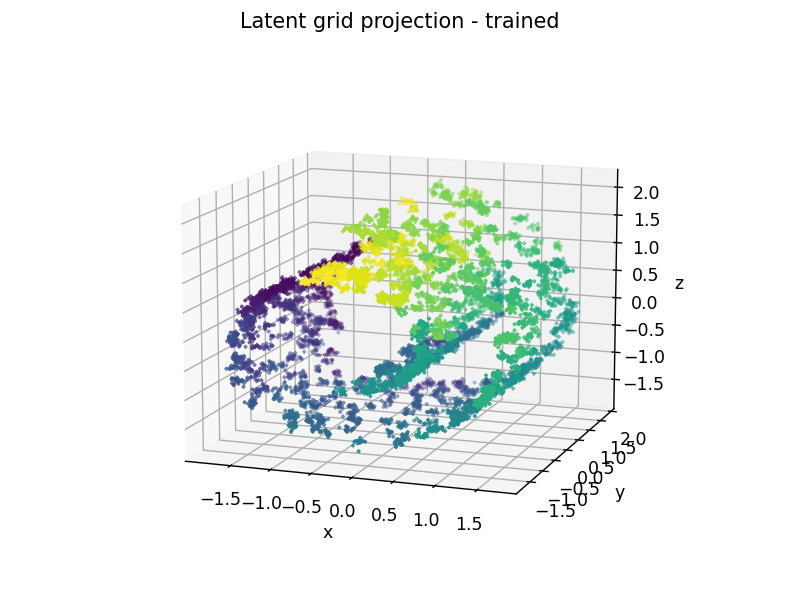

In [7]:
samples, labels = gtm.sample(10000)

fig = plt.figure()
fig.suptitle("Latent grid projection - trained")
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c = labels, s = 2, marker = "x")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
plt.show()  